In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [2]:
class CNNCifar10(nn.Module):
    def __init__(self):
        super(CNNCifar10, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, stride=1), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, stride=2), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1), nn.ReLU()
        )

        self.flatten = nn.Flatten()

        self.q_mean = self._linear(3872, 128, relu=False)
        self.q_logvar = self._linear(3872, 128, relu=False)

        self.project = self._linear(128, 3872, relu=False)

        self.unflatten = nn.Unflatten(1, (32, 11, 11))

        self.decoder = nn.Sequential(
			nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=1), nn.ReLU(),
            nn.Sigmoid()
        )

    def forward(self, x):
        enc = self.encoder(x)
        unrolled = self.flatten(enc)
        mu, lv = self.q_mean(unrolled), self.q_logvar(unrolled)
        rec_lat = self.project(self.reparam(mu, lv))
        dec = self.decoder(self.unflatten(rec_lat))
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        if self.training:
            std = torch.exp(0.5 * lv)
            eps = torch.randn(lv.size()).to(lv.device)
            return mu + std * eps
        else:
            return mu

    def _linear(self, in_size, out_size, relu=True):
        return nn.Sequential(
            nn.Linear(in_size, out_size),
            nn.ReLU(),
        ) if relu else nn.Linear(in_size, out_size)

In [3]:
def gaussian_kls(mu, logvar):
    return ((mu**2 + logvar.exp() - 1 - logvar) / 2).mean()

In [4]:
train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

trainset = CIFAR10(root='~/data', train=True, download=True, transform=train_transform)
train_dl = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=16)
testset = CIFAR10(root='~/data', train=False, download=True, transform=test_transform)
test_dl = DataLoader(testset, batch_size=256, shuffle=False, num_workers=16)

print(len(train_dl), len(test_dl))

Files already downloaded and verified
Files already downloaded and verified
196 40


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = CNNCifar10().to(device)

optimizer = Adam(params = model.parameters(), lr=5e-03, weight_decay=1e-03)

epochs = 1000

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

loss_fn = nn.BCELoss()

In [6]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss += valid_loss.item()

    print(f"Epoch: {epoch} - TrainLoss: {tr_total_loss/len(train_dl)} - ValidLoss: {va_total_loss/len(test_dl)}")

100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.20it/s]


Epoch: 0 - TrainLoss: 0.6934767824654676 - ValidLoss: 0.693148386478424


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.79it/s]


Epoch: 1 - TrainLoss: 0.6931544277740984 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.19it/s]


Epoch: 2 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.47it/s]


Epoch: 3 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.82it/s]


Epoch: 4 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.14it/s]


Epoch: 5 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.53it/s]


Epoch: 6 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.29it/s]


Epoch: 7 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.46it/s]


Epoch: 8 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.25it/s]


Epoch: 9 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 40.26it/s]


Epoch: 10 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.80it/s]


Epoch: 11 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.34it/s]


Epoch: 12 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.48it/s]


Epoch: 13 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.01it/s]


Epoch: 14 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 40.27it/s]


Epoch: 15 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.32it/s]


Epoch: 16 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.58it/s]


Epoch: 17 - TrainLoss: 0.6931471958452341 - ValidLoss: 0.6931472465395927


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.15it/s]


Epoch: 18 - TrainLoss: 0.6931471855056529 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.45it/s]


Epoch: 19 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.38it/s]


Epoch: 20 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.33it/s]


Epoch: 21 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.40it/s]


Epoch: 22 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.25it/s]


Epoch: 23 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.36it/s]


Epoch: 24 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.32it/s]


Epoch: 25 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.80it/s]


Epoch: 26 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.26it/s]


Epoch: 27 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.78it/s]


Epoch: 28 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.94it/s]


Epoch: 29 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.33it/s]


Epoch: 30 - TrainLoss: 0.6931471864179689 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 40.18it/s]


Epoch: 31 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.01it/s]


Epoch: 32 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.92it/s]


Epoch: 33 - TrainLoss: 0.6931471870261796 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 40.06it/s]


Epoch: 34 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.37it/s]


Epoch: 35 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.78it/s]


Epoch: 36 - TrainLoss: 0.6931555216409722 - ValidLoss: 0.6931473061442375


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.60it/s]


Epoch: 37 - TrainLoss: 0.6931471882426009 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.43it/s]


Epoch: 38 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.69it/s]


Epoch: 39 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 40.30it/s]


Epoch: 40 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.03it/s]


Epoch: 41 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.85it/s]


Epoch: 42 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.07it/s]


Epoch: 43 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.86it/s]


Epoch: 44 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.81it/s]


Epoch: 45 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.98it/s]


Epoch: 46 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.22it/s]


Epoch: 47 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.06it/s]


Epoch: 48 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.63it/s]


Epoch: 49 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 40.02it/s]


Epoch: 50 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.50it/s]


Epoch: 51 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.35it/s]


Epoch: 52 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.45it/s]


Epoch: 53 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.09it/s]


Epoch: 54 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.59it/s]


Epoch: 55 - TrainLoss: 0.6931471836810209 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.15it/s]


Epoch: 56 - TrainLoss: 0.6931472031437621 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.24it/s]


Epoch: 57 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.38it/s]


Epoch: 58 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.76it/s]


Epoch: 59 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.11it/s]


Epoch: 60 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.58it/s]


Epoch: 61 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.64it/s]


Epoch: 62 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.62it/s]


Epoch: 63 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.30it/s]


Epoch: 64 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.62it/s]


Epoch: 65 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.03it/s]


Epoch: 66 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.04it/s]


Epoch: 67 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.97it/s]


Epoch: 68 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.50it/s]


Epoch: 69 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.18it/s]


Epoch: 70 - TrainLoss: 0.6931471861138636 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.11it/s]


Epoch: 71 - TrainLoss: 0.6931471867220742 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.03it/s]


Epoch: 72 - TrainLoss: 0.693147284948096 - ValidLoss: 0.6931565448641777


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.32it/s]


Epoch: 73 - TrainLoss: 0.6931768564545379 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.52it/s]


Epoch: 74 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.65it/s]


Epoch: 75 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.07it/s]


Epoch: 76 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.68it/s]


Epoch: 77 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.24it/s]


Epoch: 78 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.51it/s]


Epoch: 79 - TrainLoss: 0.6931471833769156 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.83it/s]


Epoch: 80 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.60it/s]


Epoch: 81 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.40it/s]


Epoch: 82 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.63it/s]


Epoch: 83 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.88it/s]


Epoch: 84 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.11it/s]


Epoch: 85 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.65it/s]


Epoch: 86 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.56it/s]


Epoch: 87 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.09it/s]


Epoch: 88 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.37it/s]


Epoch: 89 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.02it/s]


Epoch: 90 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.13it/s]


Epoch: 91 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.49it/s]


Epoch: 92 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.61it/s]


Epoch: 93 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.39it/s]


Epoch: 94 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.02it/s]


Epoch: 95 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.51it/s]


Epoch: 96 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.96it/s]


Epoch: 97 - TrainLoss: 0.6931471830728103 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.88it/s]


Epoch: 98 - TrainLoss: 0.6931472353789271 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.97it/s]


Epoch: 99 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.89it/s]


Epoch: 100 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.08it/s]


Epoch: 101 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.88it/s]


Epoch: 102 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.86it/s]


Epoch: 103 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.10it/s]


Epoch: 104 - TrainLoss: 0.6931471833769156 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.63it/s]


Epoch: 105 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 40.07it/s]


Epoch: 106 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.61it/s]


Epoch: 107 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.05it/s]


Epoch: 108 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.99it/s]


Epoch: 109 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.11it/s]


Epoch: 110 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.77it/s]


Epoch: 111 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.05it/s]


Epoch: 112 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.98it/s]


Epoch: 113 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.53it/s]


Epoch: 114 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.70it/s]


Epoch: 115 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.39it/s]


Epoch: 116 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.18it/s]


Epoch: 117 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.76it/s]


Epoch: 118 - TrainLoss: 0.6931471958452341 - ValidLoss: 0.6931472465395927


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.85it/s]


Epoch: 119 - TrainLoss: 0.6931471867220742 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 40.44it/s]


Epoch: 120 - TrainLoss: 0.6941679889450267 - ValidLoss: 0.6934537932276725


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.79it/s]


Epoch: 121 - TrainLoss: 0.6932069318635123 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.90it/s]


Epoch: 122 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.91it/s]


Epoch: 123 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 31.35it/s]


Epoch: 124 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.50it/s]


Epoch: 125 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.26it/s]


Epoch: 126 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.09it/s]


Epoch: 127 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.84it/s]


Epoch: 128 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.56it/s]


Epoch: 129 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.34it/s]


Epoch: 130 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.91it/s]


Epoch: 131 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.32it/s]


Epoch: 132 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.83it/s]


Epoch: 133 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.29it/s]


Epoch: 134 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.43it/s]


Epoch: 135 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.49it/s]


Epoch: 136 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.67it/s]


Epoch: 137 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.49it/s]


Epoch: 138 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.17it/s]


Epoch: 139 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.39it/s]


Epoch: 140 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.60it/s]


Epoch: 141 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.50it/s]


Epoch: 142 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.19it/s]


Epoch: 143 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.05it/s]


Epoch: 144 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.89it/s]


Epoch: 145 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.85it/s]


Epoch: 146 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.44it/s]


Epoch: 147 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.96it/s]


Epoch: 148 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.71it/s]


Epoch: 149 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.45it/s]


Epoch: 150 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.64it/s]


Epoch: 151 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.81it/s]


Epoch: 152 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.00it/s]


Epoch: 153 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 40.02it/s]


Epoch: 154 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.99it/s]


Epoch: 155 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.60it/s]


Epoch: 156 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.05it/s]


Epoch: 157 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.53it/s]


Epoch: 158 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.36it/s]


Epoch: 159 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.71it/s]


Epoch: 160 - TrainLoss: 0.6931472116587113 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.17it/s]


Epoch: 161 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.25it/s]


Epoch: 162 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.33it/s]


Epoch: 163 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.19it/s]


Epoch: 164 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.90it/s]


Epoch: 165 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.48it/s]


Epoch: 166 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.88it/s]


Epoch: 167 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.94it/s]


Epoch: 168 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.48it/s]


Epoch: 169 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.58it/s]


Epoch: 170 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.17it/s]


Epoch: 171 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.32it/s]


Epoch: 172 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.72it/s]


Epoch: 173 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.85it/s]


Epoch: 174 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.39it/s]


Epoch: 175 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.16it/s]


Epoch: 176 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.99it/s]


Epoch: 177 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.62it/s]


Epoch: 178 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.09it/s]


Epoch: 179 - TrainLoss: 0.6931471873302849 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.90it/s]


Epoch: 180 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.34it/s]


Epoch: 181 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.45it/s]


Epoch: 182 - TrainLoss: 0.6931474093271761 - ValidLoss: 0.6931560680270195


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.19it/s]


Epoch: 183 - TrainLoss: 0.6931484901175207 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.94it/s]


Epoch: 184 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.56it/s]


Epoch: 185 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.98it/s]


Epoch: 186 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.08it/s]


Epoch: 187 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.60it/s]


Epoch: 188 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.95it/s]


Epoch: 189 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.45it/s]


Epoch: 190 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.07it/s]


Epoch: 191 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.77it/s]


Epoch: 192 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.45it/s]


Epoch: 193 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.35it/s]


Epoch: 194 - TrainLoss: 0.6931471833769156 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.00it/s]


Epoch: 195 - TrainLoss: 0.6931471836810209 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.90it/s]


Epoch: 196 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.63it/s]


Epoch: 197 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.10it/s]


Epoch: 198 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.57it/s]


Epoch: 199 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.74it/s]


Epoch: 200 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.21it/s]


Epoch: 201 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.20it/s]


Epoch: 202 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.76it/s]


Epoch: 203 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.77it/s]


Epoch: 204 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.35it/s]


Epoch: 205 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.53it/s]


Epoch: 206 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.84it/s]


Epoch: 207 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.67it/s]


Epoch: 208 - TrainLoss: 0.6931471833769156 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.16it/s]


Epoch: 209 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.85it/s]


Epoch: 210 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.83it/s]


Epoch: 211 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.77it/s]


Epoch: 212 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.23it/s]


Epoch: 213 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.98it/s]


Epoch: 214 - TrainLoss: 0.6931471900672329 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.21it/s]


Epoch: 215 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 29.09it/s]


Epoch: 216 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 28.32it/s]


Epoch: 217 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 28.72it/s]


Epoch: 218 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 28.56it/s]


Epoch: 219 - TrainLoss: 0.6931471906754435 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 28.24it/s]


Epoch: 220 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.73it/s]


Epoch: 221 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.09it/s]


Epoch: 222 - TrainLoss: 0.6931471985821821 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.80it/s]


Epoch: 223 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.43it/s]


Epoch: 224 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.15it/s]


Epoch: 225 - TrainLoss: 0.6931573672562229 - ValidLoss: 0.6931478425860405


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.01it/s]


Epoch: 226 - TrainLoss: 0.6931472289927152 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.77it/s]


Epoch: 227 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.29it/s]


Epoch: 228 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.54it/s]


Epoch: 229 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.83it/s]


Epoch: 230 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.97it/s]


Epoch: 231 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.32it/s]


Epoch: 232 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.32it/s]


Epoch: 233 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.19it/s]


Epoch: 234 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.02it/s]


Epoch: 235 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.13it/s]


Epoch: 236 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.55it/s]


Epoch: 237 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.47it/s]


Epoch: 238 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.58it/s]


Epoch: 239 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.74it/s]


Epoch: 240 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.13it/s]


Epoch: 241 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.32it/s]


Epoch: 242 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.10it/s]


Epoch: 243 - TrainLoss: 0.6931472101381847 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.35it/s]


Epoch: 244 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.00it/s]


Epoch: 245 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.67it/s]


Epoch: 246 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.79it/s]


Epoch: 247 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.81it/s]


Epoch: 248 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.93it/s]


Epoch: 249 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.46it/s]


Epoch: 250 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.54it/s]


Epoch: 251 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.07it/s]


Epoch: 252 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.70it/s]


Epoch: 253 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.46it/s]


Epoch: 254 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.05it/s]


Epoch: 255 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.74it/s]


Epoch: 256 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.54it/s]


Epoch: 257 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.04it/s]


Epoch: 258 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.77it/s]


Epoch: 259 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.73it/s]


Epoch: 260 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.93it/s]


Epoch: 261 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.26it/s]


Epoch: 262 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.16it/s]


Epoch: 263 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.53it/s]


Epoch: 264 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.73it/s]


Epoch: 265 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.86it/s]


Epoch: 266 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.58it/s]


Epoch: 267 - TrainLoss: 0.6931830063766363 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.93it/s]


Epoch: 268 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.45it/s]


Epoch: 269 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.43it/s]


Epoch: 270 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.35it/s]


Epoch: 271 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.68it/s]


Epoch: 272 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.01it/s]


Epoch: 273 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.01it/s]


Epoch: 274 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.36it/s]


Epoch: 275 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.45it/s]


Epoch: 276 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.24it/s]


Epoch: 277 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.11it/s]


Epoch: 278 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.71it/s]


Epoch: 279 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.06it/s]


Epoch: 280 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.18it/s]


Epoch: 281 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.70it/s]


Epoch: 282 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.80it/s]


Epoch: 283 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.75it/s]


Epoch: 284 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.61it/s]


Epoch: 285 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.66it/s]


Epoch: 286 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.84it/s]


Epoch: 287 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.94it/s]


Epoch: 288 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.21it/s]


Epoch: 289 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.32it/s]


Epoch: 290 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.45it/s]


Epoch: 291 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.75it/s]


Epoch: 292 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.86it/s]


Epoch: 293 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.93it/s]


Epoch: 294 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.66it/s]


Epoch: 295 - TrainLoss: 0.6931472779536734 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.86it/s]


Epoch: 296 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.03it/s]


Epoch: 297 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.30it/s]


Epoch: 298 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.50it/s]


Epoch: 299 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.36it/s]


Epoch: 300 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.10it/s]


Epoch: 301 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.76it/s]


Epoch: 302 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.66it/s]


Epoch: 303 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.48it/s]


Epoch: 304 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.26it/s]


Epoch: 305 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.27it/s]


Epoch: 306 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.66it/s]


Epoch: 307 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.44it/s]


Epoch: 308 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.62it/s]


Epoch: 309 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.20it/s]


Epoch: 310 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.53it/s]


Epoch: 311 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.25it/s]


Epoch: 312 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.05it/s]


Epoch: 313 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.15it/s]


Epoch: 314 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.56it/s]


Epoch: 315 - TrainLoss: 0.6931471833769156 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.58it/s]


Epoch: 316 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.46it/s]


Epoch: 317 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.22it/s]


Epoch: 318 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.21it/s]


Epoch: 319 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.23it/s]


Epoch: 320 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.69it/s]


Epoch: 321 - TrainLoss: 0.6931471867220742 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.55it/s]


Epoch: 322 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.08it/s]


Epoch: 323 - TrainLoss: 0.6931471830728103 - ValidLoss: 0.6931472465395927


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.65it/s]


Epoch: 324 - TrainLoss: 0.6931471873302849 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.80it/s]


Epoch: 325 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.96it/s]


Epoch: 326 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.81it/s]


Epoch: 327 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.15it/s]


Epoch: 328 - TrainLoss: 0.6931471894590222 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.17it/s]


Epoch: 329 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.24it/s]


Epoch: 330 - TrainLoss: 0.6931471879384956 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.03it/s]


Epoch: 331 - TrainLoss: 0.6931471833769156 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.43it/s]


Epoch: 332 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.82it/s]


Epoch: 333 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.11it/s]


Epoch: 334 - TrainLoss: 0.6931471830728103 - ValidLoss: 0.6931472465395927


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.83it/s]


Epoch: 335 - TrainLoss: 0.6931471867220742 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.35it/s]


Epoch: 336 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.42it/s]


Epoch: 337 - TrainLoss: 0.6931471873302849 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.78it/s]


Epoch: 338 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.75it/s]


Epoch: 339 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.63it/s]


Epoch: 340 - TrainLoss: 0.6931471909795489 - ValidLoss: 0.6931473061442375


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.06it/s]


Epoch: 341 - TrainLoss: 0.6931534485549343 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.49it/s]


Epoch: 342 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.38it/s]


Epoch: 343 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.07it/s]


Epoch: 344 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.52it/s]


Epoch: 345 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.86it/s]


Epoch: 346 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.14it/s]


Epoch: 347 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.40it/s]


Epoch: 348 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.84it/s]


Epoch: 349 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.29it/s]


Epoch: 350 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.29it/s]


Epoch: 351 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.82it/s]


Epoch: 352 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.34it/s]


Epoch: 353 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.08it/s]


Epoch: 354 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.27it/s]


Epoch: 355 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.83it/s]


Epoch: 356 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.65it/s]


Epoch: 357 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.75it/s]


Epoch: 358 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.56it/s]


Epoch: 359 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.75it/s]


Epoch: 360 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.14it/s]


Epoch: 361 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.14it/s]


Epoch: 362 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.35it/s]


Epoch: 363 - TrainLoss: 0.6931472405487177 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.23it/s]


Epoch: 364 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.74it/s]


Epoch: 365 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.57it/s]


Epoch: 366 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.28it/s]


Epoch: 367 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.50it/s]


Epoch: 368 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.98it/s]


Epoch: 369 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.37it/s]


Epoch: 370 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.61it/s]


Epoch: 371 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.85it/s]


Epoch: 372 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.84it/s]


Epoch: 373 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.35it/s]


Epoch: 374 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.37it/s]


Epoch: 375 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.22it/s]


Epoch: 376 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.96it/s]


Epoch: 377 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.83it/s]


Epoch: 378 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.29it/s]


Epoch: 379 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.63it/s]


Epoch: 380 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.74it/s]


Epoch: 381 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.61it/s]


Epoch: 382 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.69it/s]


Epoch: 383 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.15it/s]


Epoch: 384 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.36it/s]


Epoch: 385 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.64it/s]


Epoch: 386 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.54it/s]


Epoch: 387 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.31it/s]


Epoch: 388 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.17it/s]


Epoch: 389 - TrainLoss: 0.6931505075522831 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.85it/s]


Epoch: 390 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.74it/s]


Epoch: 391 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.40it/s]


Epoch: 392 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.38it/s]


Epoch: 393 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.44it/s]


Epoch: 394 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.92it/s]


Epoch: 395 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.72it/s]


Epoch: 396 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.49it/s]


Epoch: 397 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.03it/s]


Epoch: 398 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.16it/s]


Epoch: 399 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.24it/s]


Epoch: 400 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.40it/s]


Epoch: 401 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.30it/s]


Epoch: 402 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.61it/s]


Epoch: 403 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 41.44it/s]


Epoch: 404 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 40.43it/s]


Epoch: 405 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.41it/s]


Epoch: 406 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 40.31it/s]


Epoch: 407 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.68it/s]


Epoch: 408 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.47it/s]


Epoch: 409 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.73it/s]


Epoch: 410 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.74it/s]


Epoch: 411 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.41it/s]


Epoch: 412 - TrainLoss: 0.6931472165243966 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.23it/s]


Epoch: 413 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.35it/s]


Epoch: 414 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.59it/s]


Epoch: 415 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.09it/s]


Epoch: 416 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.23it/s]


Epoch: 417 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.87it/s]


Epoch: 418 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.12it/s]


Epoch: 419 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.69it/s]


Epoch: 420 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.02it/s]


Epoch: 421 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.27it/s]


Epoch: 422 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.01it/s]


Epoch: 423 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.56it/s]


Epoch: 424 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.68it/s]


Epoch: 425 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.71it/s]


Epoch: 426 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.24it/s]


Epoch: 427 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.42it/s]


Epoch: 428 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.43it/s]


Epoch: 429 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.72it/s]


Epoch: 430 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.49it/s]


Epoch: 431 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.09it/s]


Epoch: 432 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.16it/s]


Epoch: 433 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.88it/s]


Epoch: 434 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.59it/s]


Epoch: 435 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.67it/s]


Epoch: 436 - TrainLoss: 0.6931471848974422 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.16it/s]


Epoch: 437 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.26it/s]


Epoch: 438 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.20it/s]


Epoch: 439 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.07it/s]


Epoch: 440 - TrainLoss: 0.6931471852015476 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.90it/s]


Epoch: 441 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.06it/s]


Epoch: 442 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.38it/s]


Epoch: 443 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.78it/s]


Epoch: 444 - TrainLoss: 0.6931471879384956 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.43it/s]


Epoch: 445 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.44it/s]


Epoch: 446 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.98it/s]


Epoch: 447 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.29it/s]


Epoch: 448 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.18it/s]


Epoch: 449 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.05it/s]


Epoch: 450 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.31it/s]


Epoch: 451 - TrainLoss: 0.6931502569694908 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.66it/s]


Epoch: 452 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.64it/s]


Epoch: 453 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.10it/s]


Epoch: 454 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.61it/s]


Epoch: 455 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.23it/s]


Epoch: 456 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.06it/s]


Epoch: 457 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.04it/s]


Epoch: 458 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.24it/s]


Epoch: 459 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.38it/s]


Epoch: 460 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.82it/s]


Epoch: 461 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.26it/s]


Epoch: 462 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.90it/s]


Epoch: 463 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.24it/s]


Epoch: 464 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.15it/s]


Epoch: 465 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.96it/s]


Epoch: 466 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.98it/s]


Epoch: 467 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.12it/s]


Epoch: 468 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.59it/s]


Epoch: 469 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.29it/s]


Epoch: 470 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.74it/s]


Epoch: 471 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.04it/s]


Epoch: 472 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.02it/s]


Epoch: 473 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.69it/s]


Epoch: 474 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.15it/s]


Epoch: 475 - TrainLoss: 0.6931471873302849 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.08it/s]


Epoch: 476 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.91it/s]


Epoch: 477 - TrainLoss: 0.6931472879891493 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.52it/s]


Epoch: 478 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.29it/s]


Epoch: 479 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.14it/s]


Epoch: 480 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.74it/s]


Epoch: 481 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.59it/s]


Epoch: 482 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.41it/s]


Epoch: 483 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.04it/s]


Epoch: 484 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.36it/s]


Epoch: 485 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.92it/s]


Epoch: 486 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.00it/s]


Epoch: 487 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.47it/s]


Epoch: 488 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.66it/s]


Epoch: 489 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.77it/s]


Epoch: 490 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.44it/s]


Epoch: 491 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.47it/s]


Epoch: 492 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.66it/s]


Epoch: 493 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.67it/s]


Epoch: 494 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.56it/s]


Epoch: 495 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.67it/s]


Epoch: 496 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.87it/s]


Epoch: 497 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.46it/s]


Epoch: 498 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.68it/s]


Epoch: 499 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.73it/s]


Epoch: 500 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.56it/s]


Epoch: 501 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.48it/s]


Epoch: 502 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.00it/s]


Epoch: 503 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.04it/s]


Epoch: 504 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.11it/s]


Epoch: 505 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.76it/s]


Epoch: 506 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.89it/s]


Epoch: 507 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.21it/s]


Epoch: 508 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.31it/s]


Epoch: 509 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.21it/s]


Epoch: 510 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.19it/s]


Epoch: 511 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.44it/s]


Epoch: 512 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.35it/s]


Epoch: 513 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.68it/s]


Epoch: 514 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.79it/s]


Epoch: 515 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.83it/s]


Epoch: 516 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.86it/s]


Epoch: 517 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.80it/s]


Epoch: 518 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.75it/s]


Epoch: 519 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.81it/s]


Epoch: 520 - TrainLoss: 0.6931471830728103 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.35it/s]


Epoch: 521 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.08it/s]


Epoch: 522 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.53it/s]


Epoch: 523 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.67it/s]


Epoch: 524 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.60it/s]


Epoch: 525 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.84it/s]


Epoch: 526 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.48it/s]


Epoch: 527 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.06it/s]


Epoch: 528 - TrainLoss: 0.6931471864179689 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.90it/s]


Epoch: 529 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.80it/s]


Epoch: 530 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.97it/s]


Epoch: 531 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.04it/s]


Epoch: 532 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.37it/s]


Epoch: 533 - TrainLoss: 0.6931471833769156 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.35it/s]


Epoch: 534 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.06it/s]


Epoch: 535 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.97it/s]


Epoch: 536 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.46it/s]


Epoch: 537 - TrainLoss: 0.6931471827687049 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.81it/s]


Epoch: 538 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.61it/s]


Epoch: 539 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.00it/s]


Epoch: 540 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.38it/s]


Epoch: 541 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.67it/s]


Epoch: 542 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.56it/s]


Epoch: 543 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.96it/s]


Epoch: 544 - TrainLoss: 0.6931471852015476 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.04it/s]


Epoch: 545 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.65it/s]


Epoch: 546 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.24it/s]


Epoch: 547 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.33it/s]


Epoch: 548 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.54it/s]


Epoch: 549 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.32it/s]


Epoch: 550 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.38it/s]


Epoch: 551 - TrainLoss: 0.6931471876343902 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.57it/s]


Epoch: 552 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.47it/s]


Epoch: 553 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.02it/s]


Epoch: 554 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.95it/s]


Epoch: 555 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.26it/s]


Epoch: 556 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.42it/s]


Epoch: 557 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.04it/s]


Epoch: 558 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.64it/s]


Epoch: 559 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.92it/s]


Epoch: 560 - TrainLoss: 0.6931471827687049 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.75it/s]


Epoch: 561 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.71it/s]


Epoch: 562 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.45it/s]


Epoch: 563 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.66it/s]


Epoch: 564 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.45it/s]


Epoch: 565 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.77it/s]


Epoch: 566 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.05it/s]


Epoch: 567 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.62it/s]


Epoch: 568 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.25it/s]


Epoch: 569 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.92it/s]


Epoch: 570 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.43it/s]


Epoch: 571 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.93it/s]


Epoch: 572 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.76it/s]


Epoch: 573 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.32it/s]


Epoch: 574 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.19it/s]


Epoch: 575 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.47it/s]


Epoch: 576 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.12it/s]


Epoch: 577 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.41it/s]


Epoch: 578 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.14it/s]


Epoch: 579 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.00it/s]


Epoch: 580 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.72it/s]


Epoch: 581 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.04it/s]


Epoch: 582 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.79it/s]


Epoch: 583 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.52it/s]


Epoch: 584 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.08it/s]


Epoch: 585 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.48it/s]


Epoch: 586 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.91it/s]


Epoch: 587 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.62it/s]


Epoch: 588 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.04it/s]


Epoch: 589 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.77it/s]


Epoch: 590 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.48it/s]


Epoch: 591 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.57it/s]


Epoch: 592 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.65it/s]


Epoch: 593 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.36it/s]


Epoch: 594 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.20it/s]


Epoch: 595 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.47it/s]


Epoch: 596 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.83it/s]


Epoch: 597 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.23it/s]


Epoch: 598 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.49it/s]


Epoch: 599 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.85it/s]


Epoch: 600 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.76it/s]


Epoch: 601 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.93it/s]


Epoch: 602 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.04it/s]


Epoch: 603 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.97it/s]


Epoch: 604 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.84it/s]


Epoch: 605 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.12it/s]


Epoch: 606 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.75it/s]


Epoch: 607 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.91it/s]


Epoch: 608 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.55it/s]


Epoch: 609 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.59it/s]


Epoch: 610 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.56it/s]


Epoch: 611 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.79it/s]


Epoch: 612 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.75it/s]


Epoch: 613 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.45it/s]


Epoch: 614 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.93it/s]


Epoch: 615 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.35it/s]


Epoch: 616 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.57it/s]


Epoch: 617 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.34it/s]


Epoch: 618 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.02it/s]


Epoch: 619 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.90it/s]


Epoch: 620 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.91it/s]


Epoch: 621 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.74it/s]


Epoch: 622 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.18it/s]


Epoch: 623 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.38it/s]


Epoch: 624 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.13it/s]


Epoch: 625 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.52it/s]


Epoch: 626 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.91it/s]


Epoch: 627 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.95it/s]


Epoch: 628 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.87it/s]


Epoch: 629 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.24it/s]


Epoch: 630 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.93it/s]


Epoch: 631 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.02it/s]


Epoch: 632 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.66it/s]


Epoch: 633 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.56it/s]


Epoch: 634 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.34it/s]


Epoch: 635 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.70it/s]


Epoch: 636 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.71it/s]


Epoch: 637 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.88it/s]


Epoch: 638 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.16it/s]


Epoch: 639 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.99it/s]


Epoch: 640 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.93it/s]


Epoch: 641 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.38it/s]


Epoch: 642 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.36it/s]


Epoch: 643 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.97it/s]


Epoch: 644 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.91it/s]


Epoch: 645 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.57it/s]


Epoch: 646 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.34it/s]


Epoch: 647 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.80it/s]


Epoch: 648 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.01it/s]


Epoch: 649 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.33it/s]


Epoch: 650 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.30it/s]


Epoch: 651 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.09it/s]


Epoch: 652 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.06it/s]


Epoch: 653 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.10it/s]


Epoch: 654 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.95it/s]


Epoch: 655 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.73it/s]


Epoch: 656 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.51it/s]


Epoch: 657 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.44it/s]


Epoch: 658 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.07it/s]


Epoch: 659 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.09it/s]


Epoch: 660 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.67it/s]


Epoch: 661 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.01it/s]


Epoch: 662 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.77it/s]


Epoch: 663 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.52it/s]


Epoch: 664 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.48it/s]


Epoch: 665 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.26it/s]


Epoch: 666 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.51it/s]


Epoch: 667 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.27it/s]


Epoch: 668 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.09it/s]


Epoch: 669 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.75it/s]


Epoch: 670 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.76it/s]


Epoch: 671 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.95it/s]


Epoch: 672 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.50it/s]


Epoch: 673 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.76it/s]


Epoch: 674 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.02it/s]


Epoch: 675 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.11it/s]


Epoch: 676 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.48it/s]


Epoch: 677 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.89it/s]


Epoch: 678 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.95it/s]


Epoch: 679 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.44it/s]


Epoch: 680 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.99it/s]


Epoch: 681 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.23it/s]


Epoch: 682 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.32it/s]


Epoch: 683 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.95it/s]


Epoch: 684 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.28it/s]


Epoch: 685 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.12it/s]


Epoch: 686 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.98it/s]


Epoch: 687 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.79it/s]


Epoch: 688 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.35it/s]


Epoch: 689 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.27it/s]


Epoch: 690 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.86it/s]


Epoch: 691 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.19it/s]


Epoch: 692 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.45it/s]


Epoch: 693 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.97it/s]


Epoch: 694 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.25it/s]


Epoch: 695 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.27it/s]


Epoch: 696 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.78it/s]


Epoch: 697 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.28it/s]


Epoch: 698 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.93it/s]


Epoch: 699 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.43it/s]


Epoch: 700 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.67it/s]


Epoch: 701 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.32it/s]


Epoch: 702 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.57it/s]


Epoch: 703 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.78it/s]


Epoch: 704 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.49it/s]


Epoch: 705 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.17it/s]


Epoch: 706 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.06it/s]


Epoch: 707 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.49it/s]


Epoch: 708 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.71it/s]


Epoch: 709 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.86it/s]


Epoch: 710 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.08it/s]


Epoch: 711 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.68it/s]


Epoch: 712 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.13it/s]


Epoch: 713 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.42it/s]


Epoch: 714 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.31it/s]


Epoch: 715 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.47it/s]


Epoch: 716 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.57it/s]


Epoch: 717 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.54it/s]


Epoch: 718 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.89it/s]


Epoch: 719 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.14it/s]


Epoch: 720 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.82it/s]


Epoch: 721 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.26it/s]


Epoch: 722 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.07it/s]


Epoch: 723 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.93it/s]


Epoch: 724 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.40it/s]


Epoch: 725 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.28it/s]


Epoch: 726 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.92it/s]


Epoch: 727 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.65it/s]


Epoch: 728 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.74it/s]


Epoch: 729 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.24it/s]


Epoch: 730 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.31it/s]


Epoch: 731 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.80it/s]


Epoch: 732 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.94it/s]


Epoch: 733 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.74it/s]


Epoch: 734 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.29it/s]


Epoch: 735 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.01it/s]


Epoch: 736 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.22it/s]


Epoch: 737 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.84it/s]


Epoch: 738 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.26it/s]


Epoch: 739 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.08it/s]


Epoch: 740 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.51it/s]


Epoch: 741 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.02it/s]


Epoch: 742 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.50it/s]


Epoch: 743 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.57it/s]


Epoch: 744 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.65it/s]


Epoch: 745 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.19it/s]


Epoch: 746 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.64it/s]


Epoch: 747 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.96it/s]


Epoch: 748 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.09it/s]


Epoch: 749 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.59it/s]


Epoch: 750 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.06it/s]


Epoch: 751 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.67it/s]


Epoch: 752 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.79it/s]


Epoch: 753 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.15it/s]


Epoch: 754 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.38it/s]


Epoch: 755 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.89it/s]


Epoch: 756 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.02it/s]


Epoch: 757 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.64it/s]


Epoch: 758 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.60it/s]


Epoch: 759 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.93it/s]


Epoch: 760 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.62it/s]


Epoch: 761 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.62it/s]


Epoch: 762 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.42it/s]


Epoch: 763 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.59it/s]


Epoch: 764 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.07it/s]


Epoch: 765 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.98it/s]


Epoch: 766 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.37it/s]


Epoch: 767 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.65it/s]


Epoch: 768 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.13it/s]


Epoch: 769 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.94it/s]


Epoch: 770 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.37it/s]


Epoch: 771 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.04it/s]


Epoch: 772 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.87it/s]


Epoch: 773 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.41it/s]


Epoch: 774 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.82it/s]


Epoch: 775 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.83it/s]


Epoch: 776 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.76it/s]


Epoch: 777 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.90it/s]


Epoch: 778 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.13it/s]


Epoch: 779 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.26it/s]


Epoch: 780 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.28it/s]


Epoch: 781 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.97it/s]


Epoch: 782 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.09it/s]


Epoch: 783 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.41it/s]


Epoch: 784 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.99it/s]


Epoch: 785 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.30it/s]


Epoch: 786 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.13it/s]


Epoch: 787 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.65it/s]


Epoch: 788 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.49it/s]


Epoch: 789 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.70it/s]


Epoch: 790 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.24it/s]


Epoch: 791 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.23it/s]


Epoch: 792 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.66it/s]


Epoch: 793 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.32it/s]


Epoch: 794 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.93it/s]


Epoch: 795 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.84it/s]


Epoch: 796 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.36it/s]


Epoch: 797 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.47it/s]


Epoch: 798 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.47it/s]


Epoch: 799 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.85it/s]


Epoch: 800 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.92it/s]


Epoch: 801 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.70it/s]


Epoch: 802 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.48it/s]


Epoch: 803 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.28it/s]


Epoch: 804 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.31it/s]


Epoch: 805 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.60it/s]


Epoch: 806 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.62it/s]


Epoch: 807 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.07it/s]


Epoch: 808 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.90it/s]


Epoch: 809 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.87it/s]


Epoch: 810 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.99it/s]


Epoch: 811 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.79it/s]


Epoch: 812 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.29it/s]


Epoch: 813 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.37it/s]


Epoch: 814 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.17it/s]


Epoch: 815 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.95it/s]


Epoch: 816 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.51it/s]


Epoch: 817 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.67it/s]


Epoch: 818 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.89it/s]


Epoch: 819 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.50it/s]


Epoch: 820 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.42it/s]


Epoch: 821 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.48it/s]


Epoch: 822 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.64it/s]


Epoch: 823 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.44it/s]


Epoch: 824 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.65it/s]


Epoch: 825 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.37it/s]


Epoch: 826 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.91it/s]


Epoch: 827 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.69it/s]


Epoch: 828 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.26it/s]


Epoch: 829 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.40it/s]


Epoch: 830 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.38it/s]


Epoch: 831 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.04it/s]


Epoch: 832 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.90it/s]


Epoch: 833 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.44it/s]


Epoch: 834 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.23it/s]


Epoch: 835 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.65it/s]


Epoch: 836 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.92it/s]


Epoch: 837 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.81it/s]


Epoch: 838 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.18it/s]


Epoch: 839 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.78it/s]


Epoch: 840 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.36it/s]


Epoch: 841 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.41it/s]


Epoch: 842 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.13it/s]


Epoch: 843 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.32it/s]


Epoch: 844 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.50it/s]


Epoch: 845 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.83it/s]


Epoch: 846 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.25it/s]


Epoch: 847 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.08it/s]


Epoch: 848 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.52it/s]


Epoch: 849 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.74it/s]


Epoch: 850 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.76it/s]


Epoch: 851 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.63it/s]


Epoch: 852 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.99it/s]


Epoch: 853 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.12it/s]


Epoch: 854 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.50it/s]


Epoch: 855 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.40it/s]


Epoch: 856 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.13it/s]


Epoch: 857 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.59it/s]


Epoch: 858 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.25it/s]


Epoch: 859 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.27it/s]


Epoch: 860 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.67it/s]


Epoch: 861 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.90it/s]


Epoch: 862 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.52it/s]


Epoch: 863 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.13it/s]


Epoch: 864 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.46it/s]


Epoch: 865 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.39it/s]


Epoch: 866 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.28it/s]


Epoch: 867 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.67it/s]


Epoch: 868 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.67it/s]


Epoch: 869 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.02it/s]


Epoch: 870 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.64it/s]


Epoch: 871 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.79it/s]


Epoch: 872 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.10it/s]


Epoch: 873 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.76it/s]


Epoch: 874 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.22it/s]


Epoch: 875 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.49it/s]


Epoch: 876 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.58it/s]


Epoch: 877 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.17it/s]


Epoch: 878 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.53it/s]


Epoch: 879 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.54it/s]


Epoch: 880 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.81it/s]


Epoch: 881 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.01it/s]


Epoch: 882 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.47it/s]


Epoch: 883 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.97it/s]


Epoch: 884 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.19it/s]


Epoch: 885 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.81it/s]


Epoch: 886 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.40it/s]


Epoch: 887 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.66it/s]


Epoch: 888 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.94it/s]


Epoch: 889 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.81it/s]


Epoch: 890 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.46it/s]


Epoch: 891 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.59it/s]


Epoch: 892 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.79it/s]


Epoch: 893 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.94it/s]


Epoch: 894 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.37it/s]


Epoch: 895 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.86it/s]


Epoch: 896 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.25it/s]


Epoch: 897 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.27it/s]


Epoch: 898 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.16it/s]


Epoch: 899 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.23it/s]


Epoch: 900 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.19it/s]


Epoch: 901 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.32it/s]


Epoch: 902 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.36it/s]


Epoch: 903 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.20it/s]


Epoch: 904 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.35it/s]


Epoch: 905 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.58it/s]


Epoch: 906 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.92it/s]


Epoch: 907 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.40it/s]


Epoch: 908 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.60it/s]


Epoch: 909 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.99it/s]


Epoch: 910 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.74it/s]


Epoch: 911 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.69it/s]


Epoch: 912 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.78it/s]


Epoch: 913 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.21it/s]


Epoch: 914 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.70it/s]


Epoch: 915 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.06it/s]


Epoch: 916 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.12it/s]


Epoch: 917 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.72it/s]


Epoch: 918 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.62it/s]


Epoch: 919 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.39it/s]


Epoch: 920 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.92it/s]


Epoch: 921 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.61it/s]


Epoch: 922 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.07it/s]


Epoch: 923 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.55it/s]


Epoch: 924 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.07it/s]


Epoch: 925 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.60it/s]


Epoch: 926 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.10it/s]


Epoch: 927 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.70it/s]


Epoch: 928 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.79it/s]


Epoch: 929 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.50it/s]


Epoch: 930 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.81it/s]


Epoch: 931 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.67it/s]


Epoch: 932 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.78it/s]


Epoch: 933 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.42it/s]


Epoch: 934 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.87it/s]


Epoch: 935 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.55it/s]


Epoch: 936 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.30it/s]


Epoch: 937 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.71it/s]


Epoch: 938 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.91it/s]


Epoch: 939 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.59it/s]


Epoch: 940 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.62it/s]


Epoch: 941 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.10it/s]


Epoch: 942 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.93it/s]


Epoch: 943 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.74it/s]


Epoch: 944 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.12it/s]


Epoch: 945 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.07it/s]


Epoch: 946 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.98it/s]


Epoch: 947 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.56it/s]


Epoch: 948 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.68it/s]


Epoch: 949 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.16it/s]


Epoch: 950 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.76it/s]


Epoch: 951 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.96it/s]


Epoch: 952 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.97it/s]


Epoch: 953 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.86it/s]


Epoch: 954 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.99it/s]


Epoch: 955 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.22it/s]


Epoch: 956 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.24it/s]


Epoch: 957 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.38it/s]


Epoch: 958 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.29it/s]


Epoch: 959 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.16it/s]


Epoch: 960 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.73it/s]


Epoch: 961 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.26it/s]


Epoch: 962 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.86it/s]


Epoch: 963 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.76it/s]


Epoch: 964 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.80it/s]


Epoch: 965 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.56it/s]


Epoch: 966 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.16it/s]


Epoch: 967 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.90it/s]


Epoch: 968 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.81it/s]


Epoch: 969 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.26it/s]


Epoch: 970 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.70it/s]


Epoch: 971 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.04it/s]


Epoch: 972 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.07it/s]


Epoch: 973 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.95it/s]


Epoch: 974 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.23it/s]


Epoch: 975 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.07it/s]


Epoch: 976 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.11it/s]


Epoch: 977 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.31it/s]


Epoch: 978 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.87it/s]


Epoch: 979 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.94it/s]


Epoch: 980 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.54it/s]


Epoch: 981 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.33it/s]


Epoch: 982 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.40it/s]


Epoch: 983 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.91it/s]


Epoch: 984 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.82it/s]


Epoch: 985 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.13it/s]


Epoch: 986 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.73it/s]


Epoch: 987 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.90it/s]


Epoch: 988 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.83it/s]


Epoch: 989 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.92it/s]


Epoch: 990 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.79it/s]


Epoch: 991 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.99it/s]


Epoch: 992 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.39it/s]


Epoch: 993 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.86it/s]


Epoch: 994 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 36.76it/s]


Epoch: 995 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.06it/s]


Epoch: 996 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.51it/s]


Epoch: 997 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.52it/s]


Epoch: 998 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.55it/s]

Epoch: 999 - TrainLoss: 0.6931471824645996 - ValidLoss: 0.6931471869349479


100%|████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.71it/s]


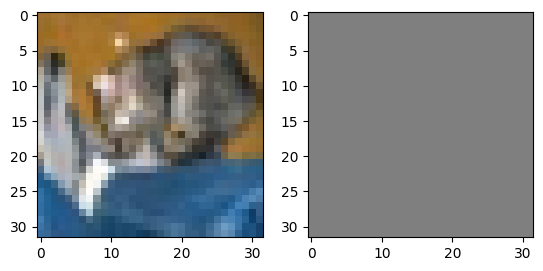

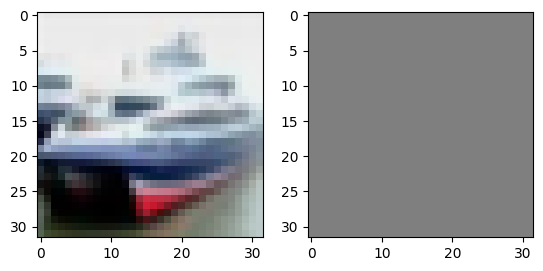

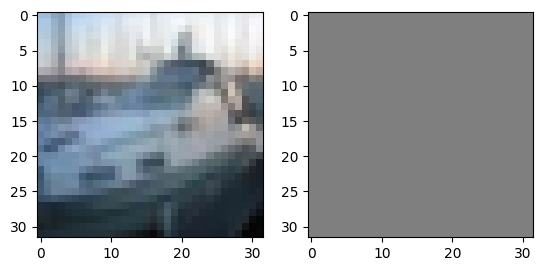

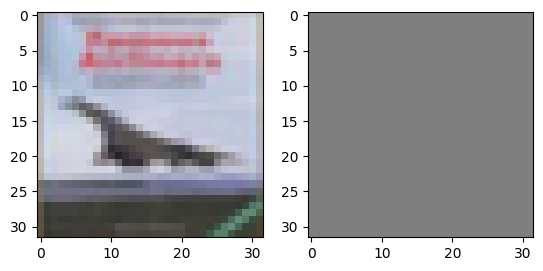

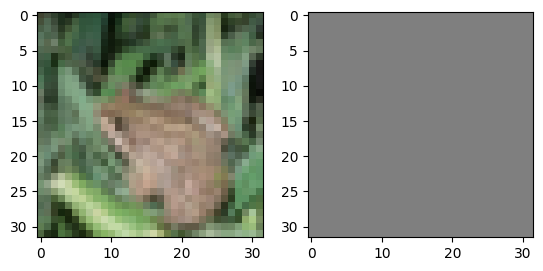

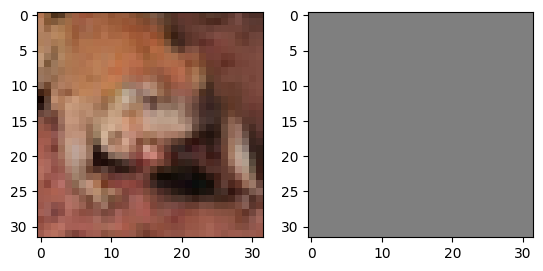

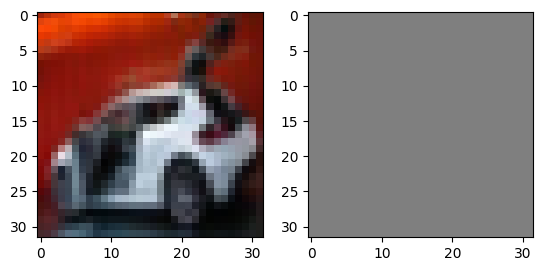

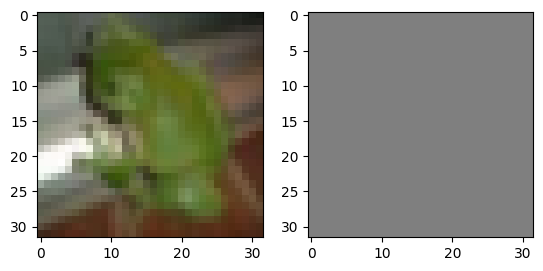

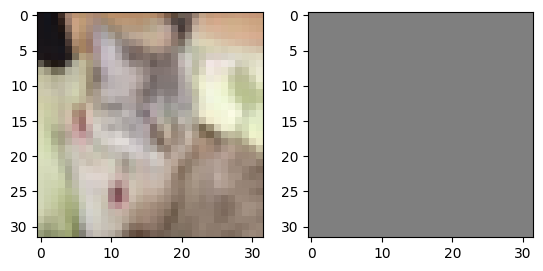

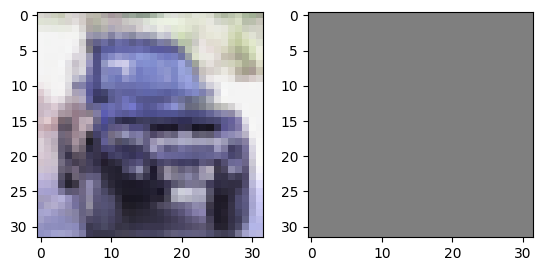

In [7]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, _ = testset[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_img, _, _ = model(valid_img)        

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].imshow(gen_img[0].cpu().permute(1, -1, 0).numpy())